In [1]:
from __future__ import absolute_import,division,print_function
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.models import Sequential, Model, load_model  # for building sequential model
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.applications import InceptionV3, ResNet50, VGG16
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import preprocess_input, decode_predictions

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image



Using TensorFlow backend.


In [2]:
#Data preprocessing

In [3]:
base_dir = '/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos'
print(os.listdir(base_dir))

['sunflowers', 'dandelion', 'tulips', 'daisy', 'roses']


In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR= os.path.join(base_dir,'daisy')
FLOWER_SUNFLOWER_DIR=os.path.join(base_dir,'sunflowers')
FLOWER_TULIP_DIR=os.path.join(base_dir,'tulips')
FLOWER_DANDI_DIR=os.path.join(base_dir,'dandelion')
FLOWER_ROSE_DIR=os.path.join(base_dir,'roses')
print(FLOWER_DAISY_DIR)
print(FLOWER_SUNFLOWER_DIR)
print(FLOWER_TULIP_DIR)
print(FLOWER_DANDI_DIR)
print(FLOWER_ROSE_DIR)

/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/daisy
/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/sunflowers
/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/tulips
/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/dandelion
/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/roses


In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

  7%|▋         | 51/699 [00:00<00:01, 509.93it/s]

633


  7%|▋         | 58/799 [00:00<00:01, 576.56it/s]

1332


  7%|▋         | 66/898 [00:00<00:01, 638.84it/s]

2131


  9%|▊         | 55/641 [00:00<00:01, 545.55it/s]

3029


100%|██████████| 641/641 [00:01<00:00, 559.78it/s]

3670


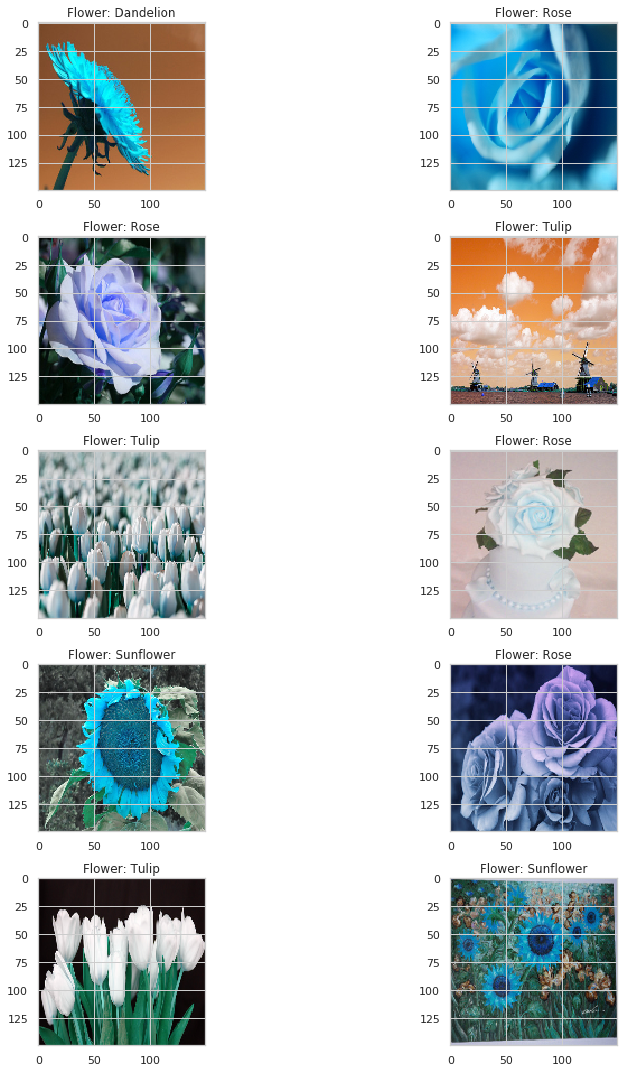

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [9]:
encoder=LabelEncoder()
Y=encoder.fit_transform(Z)


In [287]:
print('["Rose","Daisy"] labels corresponds to %s labels' %encoder.transform(["Rose","Daisy","Sunflower"]))

["Rose","Daisy"] labels corresponds to [2 0 3] labels


In [11]:
IMG_ROW = 150
IMG_COL = 150
NUM_CLASSES = 5

In [12]:
def prepare_datadf(parent_dir):
    df = pd.DataFrame(columns = ['path', 'label'])
    
    for flower in os.listdir(parent_dir):
        folder_path = os.path.join(parent_dir, flower)
        flowers = os.listdir(folder_path)
        for i in flowers:
            df = df.append(pd.DataFrame({'path':[os.path.join(flower, i)], 'label':[flower]}), 
                           ignore_index=True)
    
    # Shuffling for randomness
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df

In [155]:
# Create a dataframe with paths and labels
datadf = prepare_datadf(base_dir)
train, test = train_test_split(datadf, test_size=0.053)
val, test = train_test_split(test, test_size=0.04)

In [14]:
# Creating training and validation generators with data augmentation in train generator
gen = ImageDataGenerator(rotation_range=10, # in degrees 0-180
                        zoom_range=0.1, # 10% zoom
                        width_shift_range = 0.1, # 10% of horizontal shift
                        height_shift_range = 0.1, # 10% vertical shift
                        horizontal_flip = True, # flip horizontally
                        shear_range = 0.1, # 10% shear
                        rescale = 1./255) # bring all pixel values between 0 and 1.

valgen = ImageDataGenerator(rescale = 1./255)
# Creating train and validation generator instances to read image paths from dataframe 
train_generator=gen.flow_from_dataframe(dataframe=train, 
                                        directory=base_dir, x_col="path", y_col="label", 
                                        class_mode="categorical", target_size=(IMG_ROW,IMG_COL), 
                                        batch_size=256)
val_generator = valgen.flow_from_dataframe(dataframe=val,
                                          directory=base_dir,x_col="path", y_col="label", 
                                          class_mode="categorical", target_size=(IMG_ROW,IMG_COL), 
                                           batch_size=64)

Found 3475 images belonging to 5 classes.
Found 187 images belonging to 5 classes.


In [15]:
# Inception Net
def inception_transfer():
    # Build a Sequential Model
    model = Sequential()
    
    # Add Inception module
    base_model = InceptionV3(include_top=False, input_shape=(IMG_ROW, IMG_COL, 3))
    
    ### Freezing initial layers
    for layer in base_model.layers[:249]:
        layer.trainable = False
    
    # Setting last layers as trainable | Unfreezing later layers
    for layer in base_model.layers[249:]:
        layer.trainable = True

    model.add(base_model)
    
    # Flatten *** Most Important *** Never forget to flatten a conv output before dense
    ## This is necessary for resolving dimension errors 
    model.add(Flatten()) 
    
    # Fully connected layer 1
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(rate=0.5))
    
    # Fully connected layer 2
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    
    # Output Layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [16]:
incept_model = inception_transfer()
incept_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
__________

In [17]:
# Define training params
batch_size = 400
epochs = 20 # Set to 1 for demo, for good results set 100, Running for 100 epochs will take time.
train_steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps_per_epoch = val_generator.n//val_generator.batch_size

In [65]:
# Train the model
keras.backend.get_session().run(tf.global_variables_initializer())
incept_model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=epochs)

Epoch 1/20
13/13 [==============================] - 21s 2s/step - loss: 0.0558 - acc: 0.9816 - val_loss: 4.3322 - val_acc: 0.6484
Epoch 2/20
13/13 [==============================] - 22s 2s/step - loss: 0.0566 - acc: 0.9808 - val_loss: 3.8104 - val_acc: 0.6911
Epoch 3/20
13/13 [==============================] - 21s 2s/step - loss: 0.0582 - acc: 0.9827 - val_loss: 4.6501 - val_acc: 0.6504
Epoch 4/20
13/13 [==============================] - 21s 2s/step - loss: 0.0574 - acc: 0.9828 - val_loss: 4.5771 - val_acc: 0.6406
Epoch 5/20
13/13 [==============================] - 21s 2s/step - loss: 0.0437 - acc: 0.9867 - val_loss: 3.8549 - val_acc: 0.6667
Epoch 6/20
13/13 [==============================] - 21s 2s/step - loss: 0.0425 - acc: 0.9865 - val_loss: 3.6216 - val_acc: 0.6829
Epoch 7/20
13/13 [==============================] - 22s 2s/step - loss: 0.0438 - acc: 0.9857 - val_loss: 3.4084 - val_acc: 0.6875
Epoch 8/20
13/13 [==============================] - 21s 2s/step - loss: 0.0445 - acc: 0.98

In [382]:
PATH_IMAGE = '/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/'
test_dir = test['path'].values
test_label = test['label'].values
#print(test_dir)
#print(test_label)

def make_test_data():
    imgl = []
    for m_dir in test_dir:
        #print(m_dir)
        path = os.path.join(PATH_IMAGE,m_dir)
        #print('path',path)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (IMG_ROW,IMG_COL))
        
        imgl.append(np.array(img_resized))
    return imgl

test_images = make_test_data()

In [419]:
def model_predict(img):
    
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    plt.imshow(image)
    # Preprocess the image
    img_resized = cv2.resize(image, (IMG_ROW, IMG_COL))
    #x = test_images[3]
    x = np.expand_dims(img_resized, axis=0)
    x = preprocess_input(x)

    # Select layers for getting activations
    layer_outs = [layer.output for layer in incept_model.layers[5:]]
    
    model = Model(inputs=incept_model.input, outputs=layer_outs)
    pred = incept_model.predict(x)
    print(pred)
    pred_X = np.argmax(pred)
    return pred_X

/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/tulips/3498663243_42b39b4185_m.jpg
[[4.2132257e-15 6.8783220e-16 7.4525802e-11 8.6877194e-16 1.0000000e+00]]
predicted =  ['Tulip']
true label =  tulips


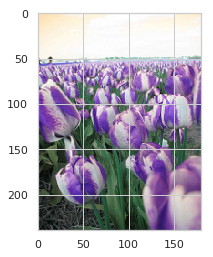

In [420]:
index = 3
IMAGE_PATH = os.path.join(PATH_IMAGE, str(test_dir[index]))
print(IMAGE_PATH)

#img = '/home/hdtung/Project/TFwithDL/final_exam/tensorflow-for-poets-2/tf_files/flower_photos/daisy/5547758_eea9edfd54_n.jpg'
print('predicted = ', encoder.inverse_transform([model_predict(IMAGE_PATH)])) 
print('true label = ', test_label[index]) 

In [377]:
#fine tuning


# SAVE MODEL

In [400]:
MODEL_DIR = '/home/hdtung/Project/TFwithDL/tfwithdl2019/'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': incept_model.input},
    outputs={t.name:t for t in incept_model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = /home/hdtung/Project/TFwithDL/tfwithdl2019/1

INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /home/hdtung/Project/TFwithDL/tfwithdl2019/1/saved_model.pb


INFO:tensorflow:SavedModel written to: /home/hdtung/Project/TFwithDL/tfwithdl2019/1/saved_model.pb



Saved model:
total 8796
-rw-rw-r-- 1 hdtung hdtung 9000057 Th06  2 09:32 saved_model.pb
drwxr-xr-x 2 hdtung hdtung    4096 Th06  2 09:32 variables


In [401]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 150, 3)
        name: inception_v3_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: dense_3/Softmax:0
  Method name is: tensorflow/serving/predict


# Start running TensorFlow Serving

In [402]:
os.environ["MODEL_DIR"] = MODEL_DIR
print(MODEL_DIR)

/home/hdtung/Project/TFwithDL/tfwithdl2019/


In [403]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=flower_serving \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [404]:
!tail server.log

2019-06-02 09:33:15.943495: I tensorflow_serving/model_servers/server_core.cc:461] Adding/updating models.
2019-06-02 09:33:15.943511: I tensorflow_serving/model_servers/server_core.cc:558]  (Re-)adding model: flower_serving
2019-06-02 09:33:16.043938: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: flower_serving version: 1}
2019-06-02 09:33:16.044420: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: flower_serving version: 1}
2019-06-02 09:33:16.044444: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: flower_serving version: 1}
2019-06-02 09:33:16.044469: I external/org_tensorflow/tensorflow/contrib/session_bundle/bundle_shim.cc:363] Attempting to load native SavedModelBundle in bundle-shim from: /home/hdtung/Project/TFwithDL/tfwithdl2019/1
2019-06-02 09:33:16.044477: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from:

# Make a request to your model in TensorFlow Serving¶

In [429]:
def show(idx, title): 
    imagesrc = test_images[idx]
    plt.figure()
    plt.imshow(imagesrc)
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
#rando = random.randint(0,len(test_dir)-1)
#show(rando, 'An Example Image: {}'.format(test_label[rando]))

Data: {"signature_name": "serving_default", "instances": ... 36108, -0.5686274766921997, -0.4745097756385803]]]]}


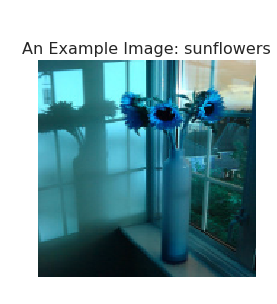

In [444]:
import json
idxtest = 4
show(idxtest, 'An Example Image: {}'.format(test_label[idxtest]))
image_test = test_images[idxtest]
image_test = np.expand_dims(image_test, axis=0)
image_test = preprocess_input(image_test)
data = json.dumps({"signature_name": "serving_default", "instances": image_test.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

# Make REST requests

In [445]:
#!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/flower_serving:predict', data=data, headers=headers)
data = json_response.json()
#print('response',data)

In [446]:
predictions = json.loads(json_response.text)['predictions']
#print('predictions',predictions)
print('predicted = ', encoder.inverse_transform([np.argmax(predictions)])) 
print('true label = ', test_label[idxtest]) 

predicted =  ['Sunflower']
true label =  sunflowers
